In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
dataset = datasets.MNIST('.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F77BB660ED0>, 5)

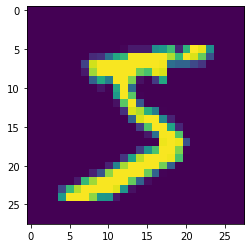

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

In [ ]:
def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),
      'target': target,
      }


In [ ]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden = 350
out_dim = 80
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
class Encoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    x = self.do(self.activ(self.linear1(x)))
    x = self.linear2(x)

    return x

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(out_dim, hidden_dim)
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, input_dim)

  def forward(self, x):
    x = self.do(self.activ(self.linear1(x)))
    x = self.linear2(x)

    return x

class LinearAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim, out_dim)
    self.decoder = Decoder(input_dim, hidden_dim, out_dim)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [ ]:
model = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()


epoch: 0, step: 0, loss: 0.015496496111154556
epoch: 0, step: 200, loss: 0.01564776711165905
epoch: 0, step: 400, loss: 0.014298796653747559


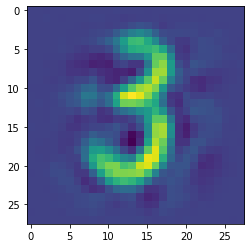

epoch: 1, step: 0, loss: 0.01456355769187212
epoch: 1, step: 200, loss: 0.014548941515386105
epoch: 1, step: 400, loss: 0.013635596260428429


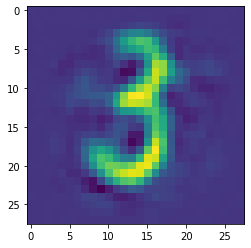

epoch: 2, step: 0, loss: 0.014566179364919662
epoch: 2, step: 200, loss: 0.01352918241173029
epoch: 2, step: 400, loss: 0.01369380485266447


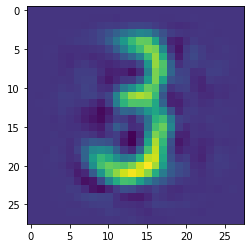

epoch: 3, step: 0, loss: 0.013617713004350662
epoch: 3, step: 200, loss: 0.012932422570884228
epoch: 3, step: 400, loss: 0.013605577871203423


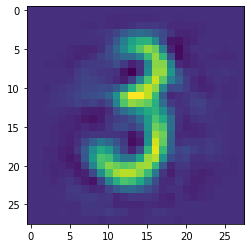

epoch: 4, step: 0, loss: 0.013435845263302326
epoch: 4, step: 200, loss: 0.014539209194481373
epoch: 4, step: 400, loss: 0.013957078568637371


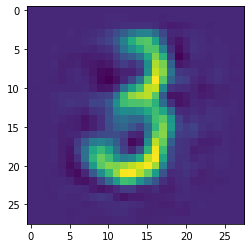

epoch: 5, step: 0, loss: 0.013017571531236172
epoch: 5, step: 200, loss: 0.013264262117445469
epoch: 5, step: 400, loss: 0.01345360279083252


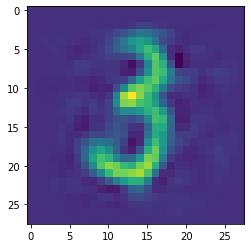

epoch: 6, step: 0, loss: 0.013394382782280445
epoch: 6, step: 200, loss: 0.013751331716775894
epoch: 6, step: 400, loss: 0.013200418092310429


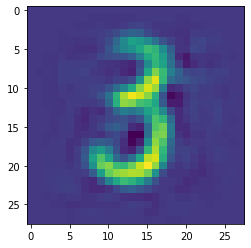

epoch: 7, step: 0, loss: 0.011674017645418644
epoch: 7, step: 200, loss: 0.013484292663633823
epoch: 7, step: 400, loss: 0.012325726449489594


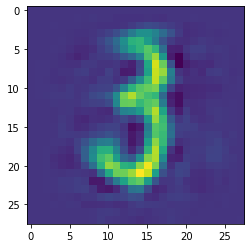

epoch: 8, step: 0, loss: 0.012622538022696972
epoch: 8, step: 200, loss: 0.013229086995124817
epoch: 8, step: 400, loss: 0.012158604338765144


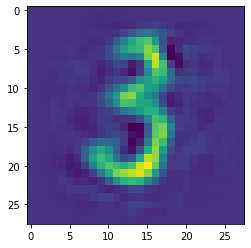

epoch: 9, step: 0, loss: 0.01246478222310543
epoch: 9, step: 200, loss: 0.01249182689934969
epoch: 9, step: 400, loss: 0.012547828257083893


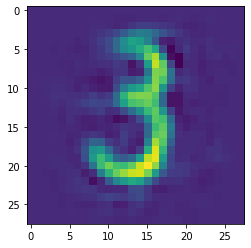

In [ ]:
# hidden_out = 40
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(batch['data'].to(device), predict)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).view(1, -1).float()/255
  plt.imshow(model(item).view((28, 28)).detach().numpy())
  plt.show()
  torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')


epoch: 0, step: 0, loss: 0.11802055686712265
epoch: 0, step: 200, loss: 0.020367808640003204
epoch: 0, step: 400, loss: 0.016873681917786598


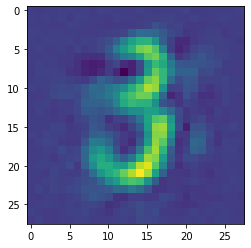

epoch: 1, step: 0, loss: 0.016682317480444908
epoch: 1, step: 200, loss: 0.015183803625404835
epoch: 1, step: 400, loss: 0.013944471254944801


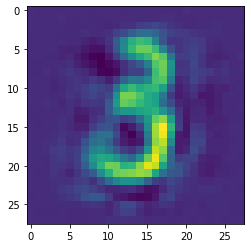

epoch: 2, step: 0, loss: 0.013212872669100761
epoch: 2, step: 200, loss: 0.013789359480142593
epoch: 2, step: 400, loss: 0.012350775301456451


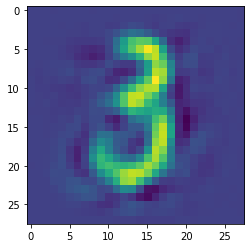

epoch: 3, step: 0, loss: 0.012831763364374638
epoch: 3, step: 200, loss: 0.012203678488731384
epoch: 3, step: 400, loss: 0.01232356671243906


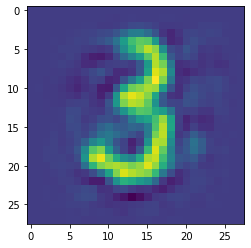

epoch: 4, step: 0, loss: 0.012393680401146412
epoch: 4, step: 200, loss: 0.011473678052425385
epoch: 4, step: 400, loss: 0.011644589714705944


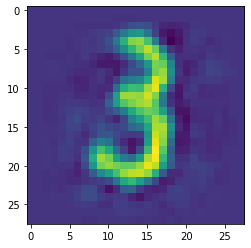

epoch: 5, step: 0, loss: 0.011741261929273605
epoch: 5, step: 200, loss: 0.012787504121661186
epoch: 5, step: 400, loss: 0.011910665780305862


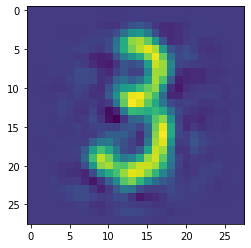

epoch: 6, step: 0, loss: 0.011721253395080566
epoch: 6, step: 200, loss: 0.011891472153365612
epoch: 6, step: 400, loss: 0.011493830941617489


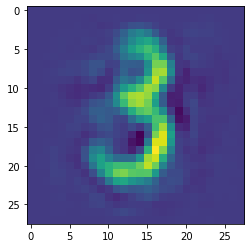

epoch: 7, step: 0, loss: 0.010700101964175701
epoch: 7, step: 200, loss: 0.011424466967582703
epoch: 7, step: 400, loss: 0.011627530679106712


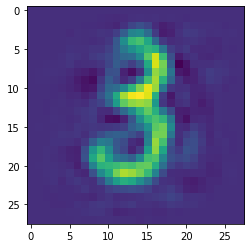

epoch: 8, step: 0, loss: 0.011907517910003662
epoch: 8, step: 200, loss: 0.01126604899764061
epoch: 8, step: 400, loss: 0.01093773078173399


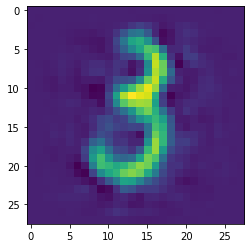

epoch: 9, step: 0, loss: 0.011310793459415436
epoch: 9, step: 200, loss: 0.010866239666938782
epoch: 9, step: 400, loss: 0.011082390323281288


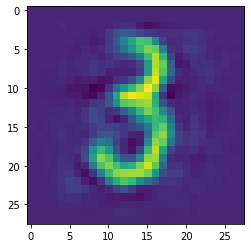

In [ ]:
# hidden_out = 80
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(batch['data'].to(device), predict)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).view(1, -1).float()/255
  plt.imshow(model(item).view((28, 28)).detach().numpy())
  plt.show()
  torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')
